In [2]:
pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 2.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.2
    Uninstalling huggingface-hub-0.23.2:
      Successfully uninstalled huggingface-hub-0.23.2
Note: you may need to restart the kernel to use updated packages.


In [4]:
from datasets import list_datasets, load_dataset
# from .autonotebook import tqdm as notebook_tqdm
import pandas as pd
import torch

In [5]:
emotions = load_dataset("emotion", trust_remote_code=True)

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Data Analysis

In [6]:
import pandas as pd

In [7]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [9]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


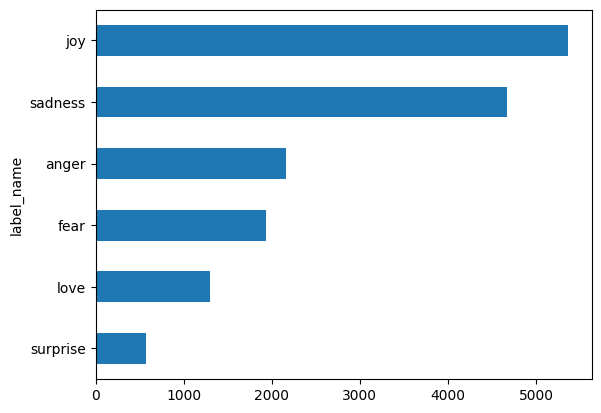

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.show()

In [11]:
emotions.reset_format()

# Tokenization

In [12]:
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModel

In [13]:
model_cktp = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_cktp)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [15]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [16]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [39]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

# Training a Text Classifier

There are 2 parts of this training section:
- Feature extraction
- Finetuning

## Transformers as Feature Extraction

In [17]:
device = torch.device('cuda')
model = AutoModel.from_pretrained(model_cktp).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

- For classification, it is common practice to just use the hidden state associated with the [CLS] token as the input feature

=> Therefore we're gonna extract the hidden state

In [23]:
def extract_hidden_states (batch):
    inputs = {k:v.to(device) for k, v in batch.items() 
             if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [25]:
# Convert inputs into tensor
emotions_encoded.set_format("torch",
                          columns = ["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [61]:
import numpy as np

hidden = emotions_hidden["train"]["hidden_state"]
X_train = hidden.numpy()
X_valid = emotions_hidden["validation"]["hidden_state"].numpy()
y_train = emotions_hidden["train"]["label"].numpy()
y_valid = emotions_hidden["validation"]["label"].numpy()
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [62]:
# Visualize training set
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

2024-06-19 15:59:22.005673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 15:59:22.005773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 15:59:22.109749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,X,Y,label
0,4.186906,6.752059,0
1,-3.080489,6.039115,0
2,5.277277,3.291888,3
3,-2.438127,4.019400,2
4,-3.466164,4.216588,3


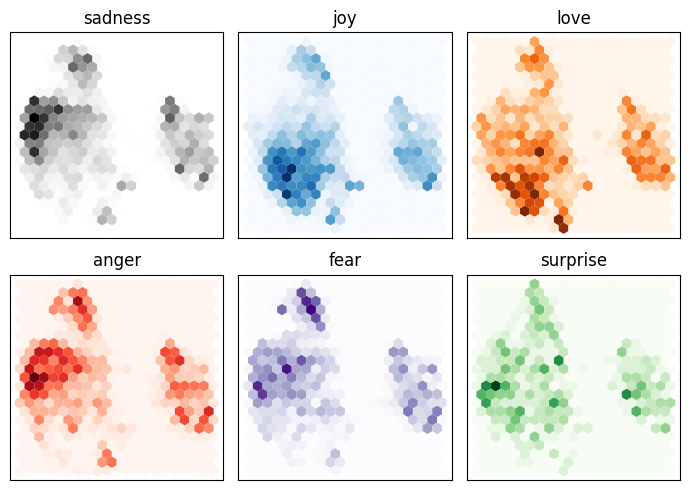

In [65]:
fig, axes = plt.subplots(2,3,figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Training Simple Classifier

In [66]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 3000)
lr.fit(X_train, y_train)
lr.score(X_valid, y_valid)

0.633

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix (y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay (confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format='.2f',ax=ax, colorbar=False)
    plt.show()

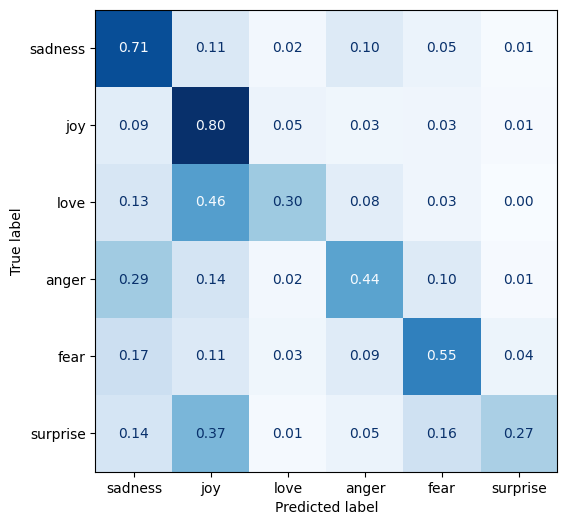

In [73]:
y_preds = lr.predict(X_valid)
plot_confusion_matrix (y_preds, y_valid, labels)

# Finetuning the Transformers

In [75]:
from transformers import AutoModelForSequenceClassification

In [77]:
num_labels=6
model = (AutoModelForSequenceClassification.from_pretrained(model_cktp, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
# Define F1 Score and Accuracy
from sklearn.metrics import f1_score, accuracy_score

def metrics (pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    return {
        "accurac": accuracy,
        "f1": f1
    }

In [79]:
from transformers import Trainer, TrainingArguments

In [82]:
batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_cktp}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error"
                                 )

In [83]:
# Trainer Initialization

trainer = Trainer (model=model, args=training_args,
                  compute_metrics=metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

In [84]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accurac,F1
1,No log,0.556184,0.825000,0.806780
2,No log,0.352867,0.899000,0.896502


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=250, training_loss=0.7627398681640625, metrics={'train_runtime': 181.3361, 'train_samples_per_second': 176.468, 'train_steps_per_second': 1.379, 'total_flos': 720342861696000.0, 'train_loss': 0.7627398681640625, 'epoch': 2.0})

In [85]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.35286661982536316,
 'test_accurac': 0.899,
 'test_f1': 0.8965017060831318,
 'test_runtime': 2.4624,
 'test_samples_per_second': 812.208,
 'test_steps_per_second': 6.498}

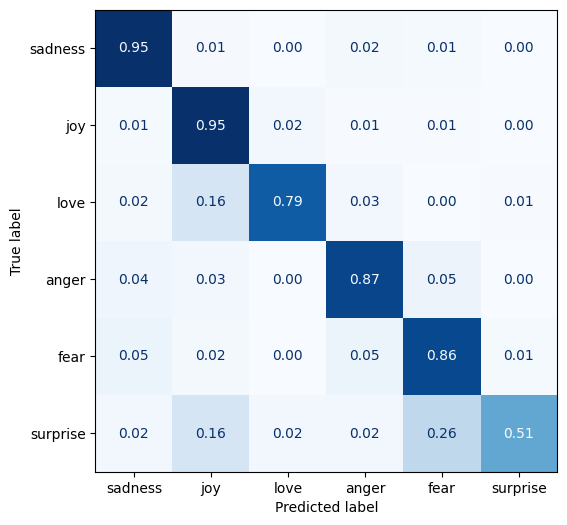

In [86]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

## Error Analysis, Forward Pass

In [87]:
from torch.nn.functional import cross_entropy

In [88]:
def forward_pass(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
             if k in tokenizer.model_input_names}
    # we do not need to compute gradient cause we only need the loss (this is not backward)
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax (output.logits, axis=-1)
        loss = cross_entropy (output.logits, batch['label'].to(device), reduction='none')
        
    return {'loss': loss.cpu().numpy(),
           'predicted_label': pred_label.cpu().numpy()}

In [89]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [90]:
# Convert into Pytorch tensors
emotions_encoded.set_format ("torch", columns=['input_ids', "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [92]:
# Compute loss value
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass, batched=True, batch_size=16)
emotions_encoded.set_format("pandas")
cols = ['text', 'label', 'predicted_label', 'loss']
df_pred = emotions_encoded ["validation"][:][cols]
df_pred['label'] = df_pred['label'].apply(label_int2str)
df_pred["predicted_label"] = (df_pred["predicted_label"].apply(label_int2str))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [94]:
# Dataframe of validation
df_pred.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.046076
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.072561
2,i feel like a faithful servant,love,joy,0.876389
3,i am just feeling cranky and blue,anger,anger,0.125256
4,i can have for a treat or if i am feeling festive,joy,joy,0.065029


In [96]:
# The highest losses
df_pred.sort_values ("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,4.854236
882,i feel badly about reneging on my commitment t...,love,sadness,4.787771
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.685152
1801,i feel that he was being overshadowed by the s...,love,sadness,4.632517
1950,i as representative of everything thats wrong ...,surprise,sadness,4.522386
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.459203
1274,i am going to several holiday parties and i ca...,joy,sadness,4.428761
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.384975
765,i feel super awkward and out of place right now,joy,sadness,4.270250
1111,im lazy my characters fall into categories of ...,joy,fear,3.990049


In [97]:
# The lowest losses
df_pred.sort_values ("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.040485
1965,i started feeling pathetic and ashamed,sadness,sadness,0.040730
1303,i feel pathetic and uninspired,sadness,sadness,0.040908
69,i have no extra money im worried all of the ti...,sadness,sadness,0.041128
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.041131
396,i feel pretty pathetic now,sadness,sadness,0.041135
34,i feel that i m so pathetic and downright dumb...,sadness,sadness,0.041175
861,i am feeling awfully lonely today and i dont w...,sadness,sadness,0.041338
1984,i have i feel pathetic for lying if i say no,sadness,sadness,0.041369
189,i leave the meeting feeling more than a little...,sadness,sadness,0.041747


# Inference

In [122]:
emotions["train"].features["label"].int2str(1)

'joy'

In [183]:
def inference (text, model, tokenizer, classes=None, prob=True):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)

    predicted_label = label_int2str(logits.argmax().item())
    if prob:
        return {label_int2str(idx) : p.item() for idx, p in enumerate(probabilities.squeeze())}
    return predicted_label

In [184]:
my_text = "Today is such a beautiful day!"

In [185]:
inference(my_text, model, tokenizer, prob=False)

'joy'

In [194]:
my_textdf = pd.DataFrame.from_dict(inference(my_text, model, tokenizer, prob=True),orient='index', columns=['Score'])
my_textdf

,Score
sadness,0.021287
joy,0.731023
love,0.185081
anger,0.016145
fear,0.012156
surprise,0.034309


In [193]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

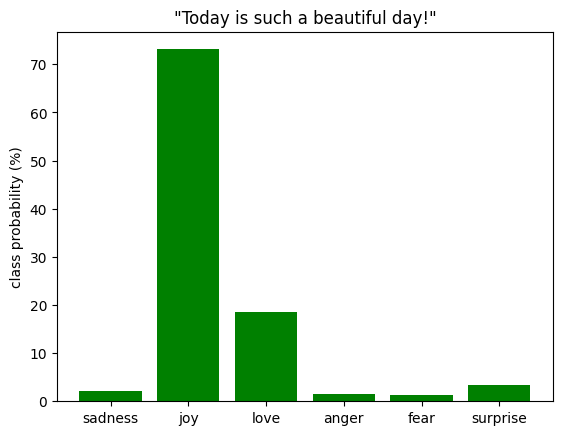

In [197]:
plt.bar(labels, 100*my_textdf['Score'], color="green")
plt.title(f'"{my_text}"')
plt.ylabel("class probability (%)")
plt.show()